# LSTM appliquées au stock market

## 0. Dowlnoad and import packages/dataset

**Download packages**

**Import packages**

In [1]:
import yfinance as yf
from ta import add_all_ta_features

import numpy as np
from numpy.random import seed
import pandas as pd
from datetime import timedelta
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

import tensorflow
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scikeras.wrappers import KerasRegressor

import optuna
from optuna.samplers import TPESampler

import plotly.graph_objects as go
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

seed(21)
tensorflow.random.set_seed(21)

c:\Users\rapha\anaconda3\envs\finance_stuff\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**DL stock data from SocGen**

In [2]:
data = yf.download("GLE.PA", start="2022-01-04", end="2024-02-20")
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-04,30.840000,32.150002,30.834999,31.924999,26.801485,6168559
2022-01-05,32.000000,32.820000,31.969999,32.250000,27.074326,4672859
2022-01-06,32.174999,33.169998,32.110001,32.849998,27.578033,4761293
2022-01-07,32.910000,33.215000,32.615002,33.200001,27.871866,3868559
2022-01-10,33.365002,33.490002,33.000000,33.014999,27.716555,3900334
...,...,...,...,...,...,...
2024-02-13,21.745001,21.855000,21.420000,21.605000,20.893009,3342689
2024-02-14,21.430000,21.870001,21.410000,21.629999,20.917185,2491765
2024-02-15,21.665001,21.915001,21.490000,21.840000,21.120264,3097884


**Vizualisation stock**

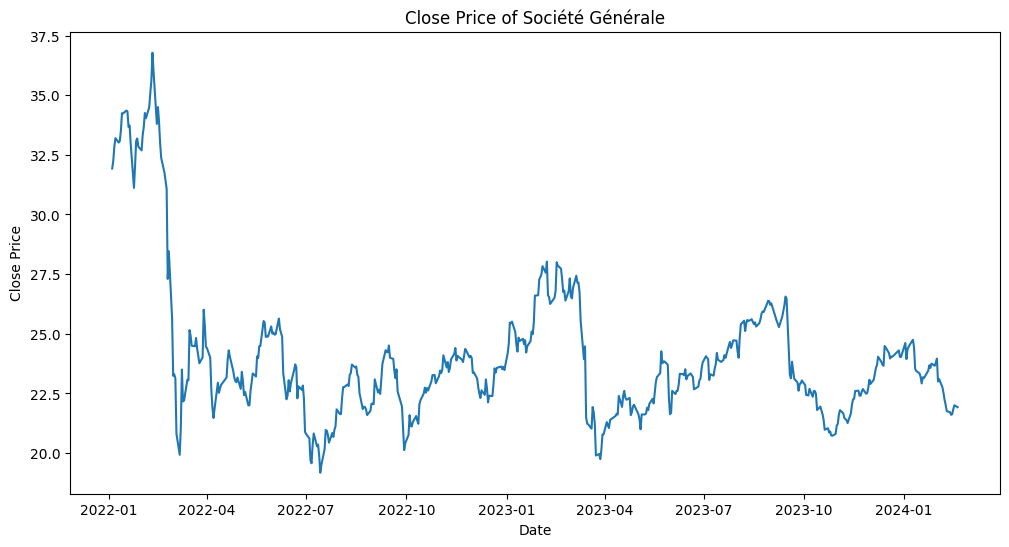

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(data['Close'])
plt.title('Close Price of Société Générale')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

## 1. Préparation des données

**Split train/test**

In [4]:
# Split train/test set
fenetre = 30

df = data['Close'].values
df = df.reshape(-1,1)

df_train = np.array(df[:int(df.shape[0]*0.8)])
df_test = np.array(df[int(df.shape[0]*0.8) - fenetre:])

**Scaling**

In [5]:
# Scaling train and test
scaler = MinMaxScaler(feature_range = (0,1))

df_train_tr = scaler.fit_transform(df_train)
df_test_tr = scaler.transform(df_test)

**Preprocessing X, y**

In [6]:
# Séquence 30 jours
def create_dataset(data, fenetre = 30):
    X, y = [], []
    for i in range(fenetre, data.shape[0]):
        X.append(data[i-fenetre:i,0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(df_train_tr)
X_test, y_test = create_dataset(df_test_tr)

In [7]:
# Redimensionnement X :
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = np.reshape(y_test, (y_test.shape[0],1))

In [8]:
# Check des transformations :
print(X_train.shape)
print(X_test.shape)

i = 0
print(df_train_tr[30+i][0] == y_train[i])
all_verified = all(df_train_tr[30+i][0] == y_train[i] for i in range(405))
print(all_verified)

(406, 30, 1)
(110, 30, 1)
[ True]
True


## 2. Modélisation LSTM

#### **2.1 Création modèle naïf**

Nous créeons dans un premier temps un modèle de prediction naïf qui nous servira de référence pour les prochains modèles. Ce modèle naïf prédit la dernière valeur observée.  

In [9]:
y_naif_pred_train = X_train[:, -1]
y_naif_pred_test = X_test[:, -1]

#### **2.2 Création modèle LSTM**

Création d'un premier modèle LSTM avec une couche de 64 neurones, et un dropout de 20%

In [10]:
# Construction du modèle et compilation
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2, seed=21))
model.add(Dense(units = 1))
model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Entrainement sur 50 epochs, taille du batch de 2 et set de validation de 20%

In [11]:
res = model.fit(X_train, y_train, epochs=50, batch_size=2, validation_split=0.2, verbose=1)

Epoch 1/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0074 - val_loss: 0.0028
Epoch 2/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 3/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 4/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0029 - val_loss: 0.0043
Epoch 5/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0032 - val_loss: 0.0050
Epoch 6/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 7/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 8/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 9/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 10/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 11/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 12/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

**Evolution loss train vs validation**

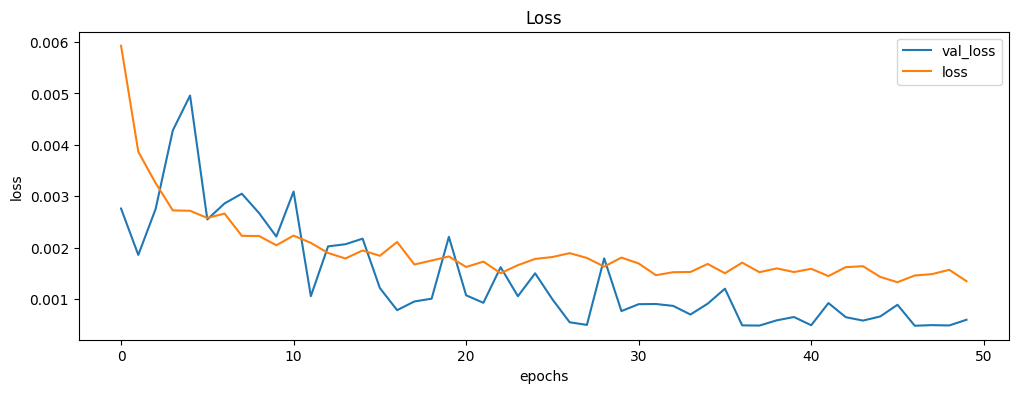

In [12]:
# See loss
def viz_results(results):
  history = results.history
  plt.figure(figsize=(12,4))
  plt.plot(history['val_loss'])
  plt.plot(history['loss'])
  plt.legend(['val_loss', 'loss'])
  plt.title('Loss')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.show()

viz_results(res)

In [13]:
predictions_train = model.predict(X_train)
predictions_train = scaler.inverse_transform(predictions_train)

predictions_test = model.predict(X_test)
predictions_test = scaler.inverse_transform(predictions_test)

predictions_naive_train = scaler.inverse_transform(y_naif_pred_train)
predictions_naive_test = scaler.inverse_transform(y_naif_pred_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


**Résultats RMSE et MAE et l'accuracy**

Nous utilisons comme métriques pour évaluer nos différents modèles le RMSE, le MAE et une accuracy custom. Cette accuracy est calculée comme le % de fois où le modèle a prévu une hausse ou baisse correct par rapport au vrai prix. 

In [14]:
def calculate_prediction_accuracy(y_test_scaled, predictions_test):
    real_diff = np.diff(y_test_scaled, axis=0)
    pred_diff = np.diff(predictions_test, axis=0)
    correct_predictions = 0

    for real, pred in zip(real_diff, pred_diff):
        if (real > 0 and pred > 0) or (real < 0 and pred < 0):
            correct_predictions += 1

    total_predictions = len(real_diff)
    accuracy_percentage = (correct_predictions / total_predictions) * 100

    return accuracy_percentage

In [15]:
y_train_scaled = scaler.inverse_transform(y_train.reshape(-1,1))
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))

In [16]:
print('-----------TRAIN RESULTS : ------------\n')
print('RMSE on train :', round(root_mean_squared_error(predictions_train, y_train_scaled),5))
print('RMSE on train w/ naïve prediction :', round(root_mean_squared_error(predictions_naive_train, y_train_scaled),5))

print('\nMAE on train :', round(mean_absolute_error(predictions_train, y_train_scaled),5))
print('MAE on train w/ naïve prediction :', round(mean_absolute_error(predictions_naive_train, y_train_scaled),5))

print('\nPrediction accuracy on train :', round(calculate_prediction_accuracy(y_train_scaled, predictions_train),5))
print('Prediction accuracy w/ naïve prediction :', round(calculate_prediction_accuracy(y_train_scaled, predictions_naive_train),5))

print('\n-----------TEST RESULTS : ------------\n')
print('RMSE on test :', round(root_mean_squared_error(predictions_test, y_test_scaled),5))
print('RMSE on test w/ naïve prediction :', round(root_mean_squared_error(predictions_naive_test, y_test_scaled),5))

print('\nMAE on test :', round(mean_absolute_error(predictions_test, y_test_scaled),5))
print('MAE on test w/ naïve prediction :', round(mean_absolute_error(predictions_naive_test, y_test_scaled),5))

print('\nPrediction accuracy on train :', round(calculate_prediction_accuracy(y_test_scaled, predictions_test),5))
print('Prediction accuracy w/ naïve prediction :', round(calculate_prediction_accuracy(y_test_scaled, predictions_naive_test),5))

-----------TRAIN RESULTS : ------------

RMSE on train : 0.58655
RMSE on train w/ naïve prediction : 0.58862

MAE on train : 0.41603
MAE on train w/ naïve prediction : 0.38769

Prediction accuracy on train : 50.37037
Prediction accuracy w/ naïve prediction : 48.88889

-----------TEST RESULTS : ------------

RMSE on test : 0.41201
RMSE on test w/ naïve prediction : 0.41311

MAE on test : 0.25692
MAE on test w/ naïve prediction : 0.23982

Prediction accuracy on train : 56.88073
Prediction accuracy w/ naïve prediction : 55.04587


Nous voyons que notre premier modèle LSTM obtient des résulats similaires à une prédiction naïve sur la dernière valeur de prix.

**Vizualisation predictions**

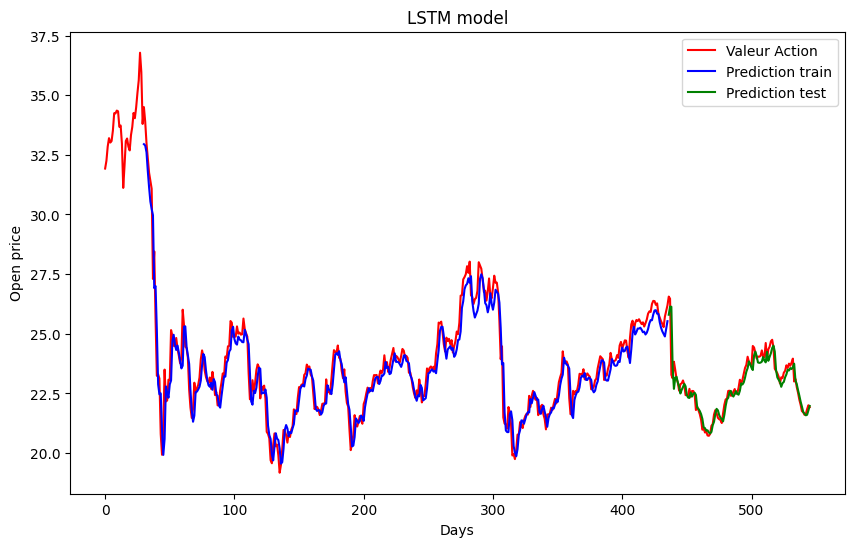

In [256]:
fig, ax = plt.subplots(figsize= (10,6))
plt.plot(df, color = 'red', label = 'Valeur Action')
ax.plot(range(fenetre, len(y_train) + fenetre), predictions_train, color = 'blue', label = 'Prediction train')
ax.plot(range(fenetre + len(y_train), len(y_train) + fenetre+ len(predictions_test)) , predictions_test, color = 'green', label = 'Prediction test')
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("LSTM model")
plt.legend()
plt.show()

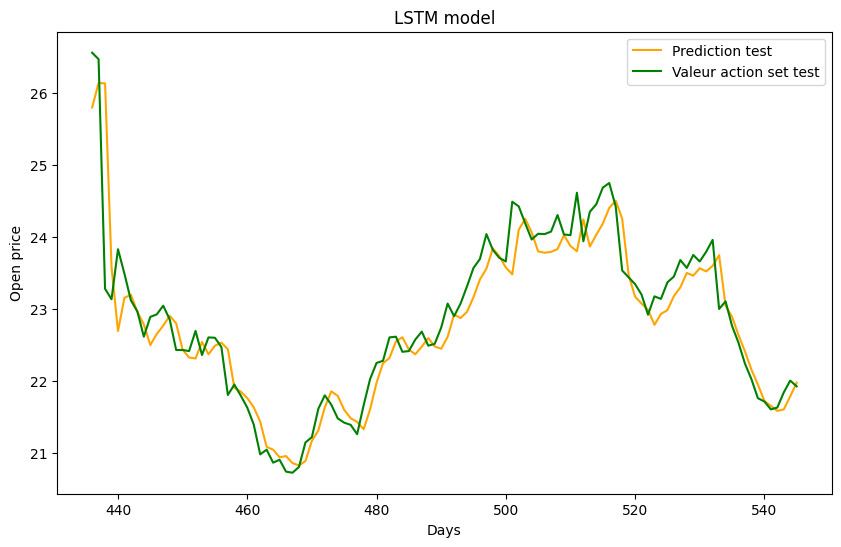

In [255]:
plt.subplots(figsize =(10,6))
plt.plot(range(fenetre + len(y_train), len(y_train) + fenetre+ len(predictions_test)), predictions_test, label = "Prediction test", c = "orange" )
plt.plot(range(fenetre + len(y_train), len(y_train) + fenetre+ len(predictions_test)), y_test_scaled, label = "Valeur action set test", color = "g")

plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("LSTM model")
plt.legend()
plt.show()

Les résults de notre modèle semble se confirmer, en effet le modèle semble prédire la dernière valeur de prix.

## 3. LSTM optimisé

Dans cette partie, nous allons tenter d'améliorer notre LSTM en tunant les différents hyperparamètres ainsi que la strucuture du réseau. Pour cela nous utilisons un algorithme d'optimisation bayésienne via la librarie Optuna. Les paramètres à optimiser sont :  

- le nombre de neurones  
- le type d'activation
- l'algorithme d'optimisation utilisée
- le learning rate
- le batch_size
- le nombre d'epochs
- la structure du réseau via le nombre de couches par layers
- l'utilisation de dropout ou non avec le dropout_rate
- l'ajout d'une normalization
- l'utilisation d'un early stopping
- la fenetre
- la période d'entrainement

Dans notre cas, la fonction objective à maximiser pour nos hyperparamètres est l'erreur quadatrique moyenne négative (-MSE) obtenue lors de la dernière époque sur le set de validation.

#### **3.1 Fonctions de tuning**

In [257]:
def get_time_series_combination(list_date):
    combinations = []
    for i in range(len(list_date) - 1):
        add_list = []
        for j in range(len(list_date) - 1 -i):
            add_list.append([list_date[j], list_date[j+i+1]])
        combinations += add_list

    return combinations

In [258]:
def get_X_and_y(data, begin, end, fenetre):
  date_threshold = pd.to_datetime(begin)
  date_end = pd.to_datetime(end)
  data_time = data.loc[(data.index >= date_threshold) & (data.index < date_end)]

  df = data_time['Close'].values
  df = df.reshape(-1,1)

  df_train = np.array(df[:int(df.shape[0])])
  scaler = MinMaxScaler(feature_range = (0,1))
  df_train_tr = scaler.fit_transform(df_train)

  X_train, y_train = create_dataset(df_train_tr, fenetre) ## !! Mettre fenetre en parametre de la fonction avant

  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
  y_train = np.reshape(y_train, (y_train.shape[0],1))

  return X_train, y_train, scaler

In [259]:
data_all = yf.download("GLE.PA", start="2007-05-01", end="2023-08-03") ## On s'arrete juste avant le set de test

date_strings = [f'{year}-01-05' for year in range(2007, 2024, 2)]
all_combinations = get_time_series_combination(date_strings)

[*********************100%%**********************]  1 of 1 completed


In [260]:
# Function to create model
def nn_cl_bo2(neurons, activation, optimizer, learning_rate, batch_size, epochs,
              layers1, layers2, normalization, dropout, dropout_rate,
              period, fenetre, get_model = False):

    X, y, sc = get_X_and_y(data_all, period[0], period[1], fenetre)

    optimizerL = ['SGD',
                  'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl']
    optimizerD= {'Adam':Adam(learning_rate=learning_rate), 'SGD':SGD(learning_rate=learning_rate),
                 'RMSprop':RMSprop(learning_rate=learning_rate), 'Adadelta':Adadelta(learning_rate=learning_rate),
                 'Adagrad':Adagrad(learning_rate=learning_rate), 'Adamax':Adamax(learning_rate=learning_rate),
                 'Nadam':Nadam(learning_rate=learning_rate), 'Ftrl':Ftrl(learning_rate=learning_rate)}
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu','relu']

    activation = activationL[activation]
    optimizer = optimizerD[optimizerL[optimizer]]

    def nn_cl_fun():
        nn = Sequential()
        nn.add(LSTM(units=neurons, activation=activation, return_sequences=True,  input_shape=(X_train.shape[1], 1)))
        if normalization:
            nn.add(BatchNormalization())
        for i in range(layers1):
             nn.add(LSTM(units=neurons, activation=activation, return_sequences=True))
        if dropout:
            nn.add(Dropout(dropout_rate, seed=21))
        for i in range(layers2-1):
            nn.add(LSTM(units=neurons, activation=activation, return_sequences=True))
        nn.add(LSTM(units=neurons, activation=activation))
        if dropout:
            nn.add(Dropout(dropout_rate, seed=21))
        nn.add(Dense(units =1))
        nn.compile(optimizer=optimizer, loss='mean_squared_error')
        return nn

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=round(15))
    nn = KerasRegressor(nn_cl_fun(), epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[es], verbose=0)

    if get_model:
        return nn, sc

    res = nn.fit(X, y)
    mse = res.history_['val_loss'][-1]
    return mse


In [14]:
def objectiveLSTM(trial:optuna.Trial):
  # list des hyperparmaètres
    neurons = trial.suggest_int('neurons', 4, 64)
    activation = trial.suggest_int('activation', 0, 7)
    optimizer = trial.suggest_int('optimizer', 0, 7)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1, log = True)
    batch_size = trial.suggest_int('batch_size', 2, 100, log=True)
    epochs = trial.suggest_int('epochs', 10, 100)
    layers1 = trial.suggest_int('layers1', 1, 2)
    layers2 = trial.suggest_int('layers2', 0, 2)
    normalization = trial.suggest_categorical('normalization', [True, False]),
    dropout = trial.suggest_categorical('dropout', [True, False]),
    dropout_rate = trial.suggest_float('dropout_rate', 0, 0.3)

    period = trial.suggest_categorical('period', all_combinations)
    fenetre = trial.suggest_int('fenetre', 10, 50)

    return nn_cl_bo2(neurons=neurons, activation=activation, optimizer=optimizer, learning_rate=learning_rate,
              batch_size=batch_size, epochs=epochs,  layers1=layers1, layers2=layers2,
              normalization=normalization, dropout=dropout, dropout_rate=dropout_rate,
              period=period, fenetre=fenetre
              )

In [15]:
sampler = TPESampler(seed=21)
study_LSTM = optuna.create_study(direction='minimize', sampler = sampler)
study_LSTM.optimize(objectiveLSTM, n_trials = 50)

[I 2024-06-05 13:34:40,493] A new study created in memory with name: no-name-6cbadabd-4464-44d6-b679-818536e0e1a1
[I 2024-06-05 13:35:04,957] Trial 0 finished with value: 0.5401148796081543 and parameters: {'neurons': 6, 'activation': 2, 'optimizer': 5, 'learning_rate': 0.00012202954716409934, 'batch_size': 4, 'epochs': 14, 'layers1': 1, 'layers2': 1, 'normalization': False, 'dropout': False, 'dropout_rate': 0.03997215577552432, 'period': ['2015-01-05', '2017-01-05'], 'fenetre': 46}. Best is trial 0 with value: 0.5401148796081543.
[I 2024-06-05 13:36:13,777] Trial 1 finished with value: 0.07792079448699951 and parameters: {'neurons': 46, 'activation': 3, 'optimizer': 2, 'learning_rate': 0.1906942595428759, 'batch_size': 3, 'epochs': 46, 'layers1': 1, 'layers2': 1, 'normalization': True, 'dropout': True, 'dropout_rate': 0.19970809433225845, 'period': ['2015-01-05', '2023-01-05'], 'fenetre': 27}. Best is trial 1 with value: 0.07792079448699951.
[I 2024-06-05 13:36:47,526] Trial 2 finishe

In [236]:
study_LSTM.best_params

{'neurons': 29,
 'activation': 4,
 'optimizer': 1,
 'learning_rate': 0.0002952132980400031,
 'batch_size': 5,
 'epochs': 95,
 'layers1': 1,
 'layers2': 2,
 'normalization': False,
 'dropout': True,
 'dropout_rate': 0.023191027805970738,
 'period': ['2007-01-05', '2017-01-05'],
 'fenetre': 14}

In [261]:
best_model, sc = nn_cl_bo2(**study_LSTM.best_params, get_model=True)

best_params = study_LSTM.best_params
X, y, sc = get_X_and_y(data_all, best_params['period'][0], best_params['period'][1], best_params['fenetre'])

best_res = best_model.fit(X, y)
best_res

KerasRegressor(
	model=<Sequential name=sequential_64, built=True>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=5
	validation_batch_size=None
	verbose=0
	callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x000001E0B6045490>]
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=95
)

In [262]:
## Création du set de test X et y avec la bonne fenetre
data_test = data.loc[(data.index >= pd.to_datetime('2023-08-03')) & (data.index < pd.to_datetime('2024-02-20'))]
df = data_test['Close'].values
df = df.reshape(-1,1)
df_test = np.array(df[:int(df.shape[0])])
df_test_tr = sc.transform(df_test)
X_test, y_test = create_dataset(df_test_tr, fenetre =best_params['fenetre'])

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = np.reshape(y_test, (y_test.shape[0],1))

In [263]:
tuned_pred_test = best_model.predict(X_test)
tuned_pred_test = sc.inverse_transform(tuned_pred_test)
y_test_scaled = sc.inverse_transform(y_test.reshape(-1,1))

In [264]:
y_naif_pred_test = X_test[:, -1]
predictions_naive_test = sc.inverse_transform(y_naif_pred_test)

In [266]:
print('\n-----------TEST RESULTS : ------------\n')
print('RMSE on test :', round(root_mean_squared_error(tuned_pred_test, y_test_scaled),5))
print('RMSE on test w/ naïve prediction :', round(root_mean_squared_error(predictions_naive_test, y_test_scaled),5))

print('\nMAE on test :', round(mean_absolute_error(tuned_pred_test, y_test_scaled),5))
print('MAE on test w/ naïve prediction :', round(mean_absolute_error(predictions_naive_test, y_test_scaled),5))

print('\nPrediction accuracy on train :', round(calculate_prediction_accuracy(y_test_scaled, tuned_pred_test),5))
print('Prediction accuracy w/ naïve prediction :', round(calculate_prediction_accuracy(y_test_scaled, predictions_naive_test),5))


-----------TEST RESULTS : ------------

RMSE on test : 0.57787
RMSE on test w/ naïve prediction : 0.39415

MAE on test : 0.4409
MAE on test w/ naïve prediction : 0.2329

Prediction accuracy on train : 57.6
Prediction accuracy w/ naïve prediction : 56.0


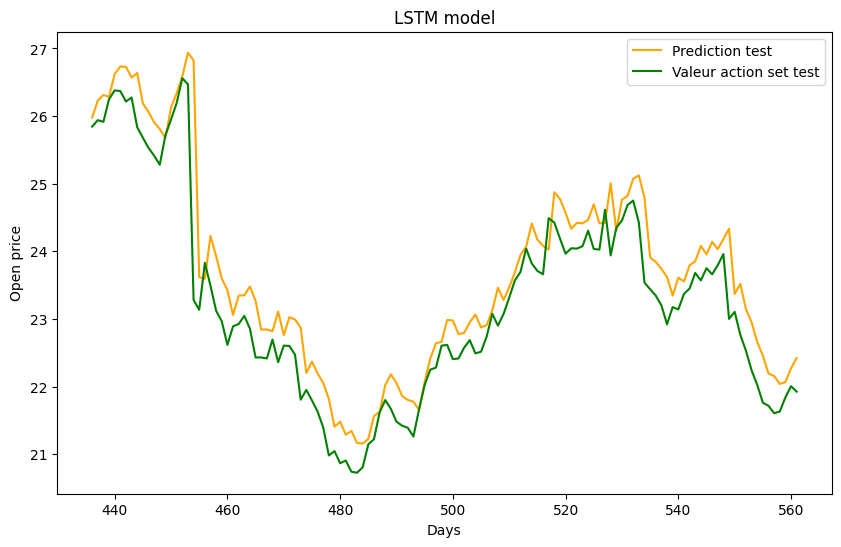

In [269]:
plt.subplots(figsize =(10,6))
plt.plot(range(fenetre + len(y_train), len(y_train) + fenetre+ len(tuned_pred_test)), tuned_pred_test, label = "Prediction test", c = "orange" )
plt.plot(range(fenetre + len(y_train), len(y_train) + fenetre+ len(tuned_pred_test)), y_test_scaled, label = "Valeur action set test", color = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("LSTM model")
plt.legend()
plt.show()

Malgré l'étape de tuning nous voyons que nous ne dépassons pas les performances des prédictions naïves et meme probablement overfit le set de train. Il peut alors être intéressant d'essayer de rajouter d'autres variables explicatives a notre réseau LSTM. 

## 4. Feature engineering et LSTM multivariée

Dans cette partie nous allons rajouter des variables explicatives à notre modèles en plus de l'historique des prix. Nous rajoutons pour cela des variables d'analyses techniques issues de la libraire python Technical Analysis. Nous nous limitons pour l'instant à 10 variables issues de différents indicateurs (momentum, trend folowing, ect.).

In [17]:
new_data = yf.download("GLE.PA", start="2007-01-04", end="2024-02-20")
data_upd = add_all_ta_features(new_data, open="Open", high="High", low="Low", close="Close", volume="Volume")
data_upd

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-01-04,117.039688,117.933121,116.861000,117.486404,60.249538,1768677,2.947816e+05,1768677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.000000,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,118.498962,116.354721,NaN,0.527778,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.397060,NaN,0.000000,0.000000,0.000000,NaN,38.253381,38.994564,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2007-01-05,117.307716,118.022461,116.414284,116.682312,59.837204,1531981,-7.265415e+05,236696,NaN,NaN,-18.757546,NaN,-1.048508e+04,NaN,NaN,993.155868,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,118.573413,115.893115,NaN,0.294444,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.218372,NaN,0.000000,0.000000,0.000000,NaN,38.253381,38.994564,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.684413,-0.686766,-0.684413
2007-01-08,116.592972,117.397057,115.967567,116.146255,59.562283,1464269,-1.824739e+06,-1227573,NaN,NaN,-52.332763,NaN,-1.721216e+04,NaN,NaN,988.593157,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,118.359980,115.620122,NaN,0.192029,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,116.995014,NaN,0.000000,0.000000,0.000000,NaN,38.253381,38.994564,NaN,NaN,NaN,NaN,117.933121,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.459415,-0.460474,-1.140684
2007-01-09,116.503624,117.218376,115.878227,115.878227,59.424843,1936632,-3.761371e+06,-3164205,NaN,NaN,-9.273511,NaN,-2.168128e+04,NaN,NaN,988.593157,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,118.186258,115.461290,NaN,0.153006,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,116.950344,NaN,0.000000,0.000000,0.000000,NaN,38.253381,38.994564,NaN,NaN,NaN,NaN,118.022461,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.230768,-0.231035,-1.368820
2007-01-10,115.163475,115.610191,113.823326,115.074135,59.012470,2050230,-2.941272e+06,-5214435,NaN,NaN,-159.626991,NaN,-3.590806e+04,NaN,NaN,988.593157,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,117.873557,114.978836,NaN,0.032922,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115.922894,NaN,0.000000,0.000000,0.000000,NaN,38.253381,38.994564,NaN,NaN,NaN,NaN,117.936692,0.0,0.0,NaN,NaN,NaN,NaN

#### **4.1 Preparation X et y**

In [62]:
#df = data_upd.drop(['trend_psar_up'], axis = 1).dropna().values
df = data_upd.drop(['Open', 'High', 'Low', 'trend_psar_up'], axis = 1).dropna().values

fenetre = 30
prop = 0.8

df_train = np.array(df[:int(df.shape[0] * prop)])
df_test = np.array(df[int(df.shape[0] * prop) - fenetre:])

scaler = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

scaler_y.fit(df_train[:,0].reshape(-1, 1))
df_train_tr = scaler.fit_transform(df_train)
df_test_tr = scaler.transform(df_test)

def create_dataset(data, fenetre=30):
    X, y = [], []
    for i in range(fenetre, data.shape[0]):
        X.append(data[i - fenetre:i])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(df_train_tr, fenetre)
X_test, y_test = create_dataset(df_test_tr, fenetre)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(X_train.shape)
print(X_test.shape)

(1715, 30, 88)
(437, 30, 88)


#### **4.2 Modélisation**

In [63]:
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error')

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 30, 64)         │        39,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,257 (282.25 KB)

 Trainable params: 72,257 (282.25 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
res = model.fit(X_train, y_train, epochs=30, batch_size=4, validation_split=0.2, verbose=1)

Epoch 1/30
343/343 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0091 - val_loss: 2.9464e-04
Epoch 2/30
343/343 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0016 - val_loss: 2.4226e-04
Epoch 3/30
343/343 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0014 - val_loss: 2.8400e-04
Epoch 4/30
343/343 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0012 - val_loss: 6.1706e-04
Epoch 5/30
343/343 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0013 - val_loss: 3.2400e-04
Epoch 6/30
343/343 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.0228e-04 - val_loss: 2.0332e-04
Epoch 7/30
343/343 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.6417e-04 - val_loss: 1.7594e-04
Epoch 8/30
343/343 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.8175e-04 - val_loss: 1.7305e-04
Epoch 9/30
343/343 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 7.3530e-04 - val_loss: 1.4553e-04
Epoch 10/30
343/343 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 7.2236e-04 - val_loss: 9.8385e-05
Epoch 11/30
343/343 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.7050e-04 - val_l

#### **4.3 Prédictions et résultats**

In [65]:
y_naif_pred_train = X_train[:, -1][:,0]
y_naif_pred_test = X_test[:, -1][:,0]

In [66]:
predictions_train = model.predict(X_train)
predictions_train = scaler_y.inverse_transform(predictions_train)

predictions_test = model.predict(X_test)
predictions_test = scaler_y.inverse_transform(predictions_test)

predictions_naive_train = scaler_y.inverse_transform(y_naif_pred_train.reshape(-1,1))
predictions_naive_test = scaler_y.inverse_transform(y_naif_pred_test.reshape(-1,1))

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [67]:
y_train_scaled = scaler_y.inverse_transform(y_train.reshape(-1,1))
y_test_scaled = scaler_y.inverse_transform(y_test.reshape(-1,1))

In [69]:
print('-----------TRAIN RESULTS : ------------\n')
print('RMSE on train :', round(root_mean_squared_error(predictions_train, y_train_scaled),5))
print('RMSE on train w/ naïve prediction :', round(root_mean_squared_error(predictions_naive_train, y_train_scaled),5))

print('\nMAE on train :', round(mean_absolute_error(predictions_train, y_train_scaled),5))
print('MAE on train w/ naïve prediction :', round(mean_absolute_error(predictions_naive_train, y_train_scaled),5))

print('\nPrediction accuracy on train :', round(calculate_prediction_accuracy(y_train_scaled, predictions_train),5))
print('Prediction accuracy w/ naïve prediction :', round(calculate_prediction_accuracy(y_train_scaled, predictions_naive_train),5))

print('\n-----------TEST RESULTS : ------------\n')
print('RMSE on test :', round(root_mean_squared_error(predictions_test, y_test_scaled),5))
print('RMSE on test w/ naïve prediction :', round(root_mean_squared_error(predictions_naive_test, y_test_scaled),5))

print('\nMAE on test :', round(mean_absolute_error(predictions_test, y_test_scaled),5))
print('MAE on test w/ naïve prediction :', round(mean_absolute_error(predictions_naive_test, y_test_scaled),5))

print('\nPrediction accuracy on train :', round(calculate_prediction_accuracy(y_test_scaled, predictions_test),5))
print('Prediction accuracy w/ naïve prediction :', round(calculate_prediction_accuracy(y_test_scaled, predictions_naive_test),5))

-----------TRAIN RESULTS : ------------

RMSE on train : 2.63211
RMSE on train w/ naïve prediction : 1.42344

MAE on train : 1.68955
MAE on train w/ naïve prediction : 0.88552

Prediction accuracy on train : 50.05834
Prediction accuracy w/ naïve prediction : 48.13302

-----------TEST RESULTS : ------------

RMSE on test : 1.48995
RMSE on test w/ naïve prediction : 0.80893

MAE on test : 1.19606
MAE on test w/ naïve prediction : 0.48

Prediction accuracy on train : 49.77064
Prediction accuracy w/ naïve prediction : 49.31193


In [70]:
x_range = list(range(fenetre + len(y_train), len(y_train) + fenetre + len(predictions_test)))
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x_range,
    y=predictions_test.flatten(),
    mode='lines',
    name='Prediction test',
    line=dict(color='orange')
))

fig.add_trace(go.Scatter(
    x=x_range,
    y=y_test_scaled.flatten(),
    mode='lines',
    name='Valeur action set test',
    line=dict(color='green')
))

fig.update_layout(
    title='LSTM model',
    xaxis_title='Days',
    yaxis_title='Open price',
    legend=dict(x=0, y=1), 
    width=1000,  
    height=600   
)

fig.show()

## 5. Predictions de plusieurs valeurs de prix

#### **5.1 Data Preparation**

Cette fois-ci nous allons essayer de prédire non pas une seule valeur de prix mais les 30 prochaines. Dans cette configuration le vecteur $y$ n'est plus de taille $n \times 1$ mais $n \times 30$

In [278]:
list_signals = ['Close', 'momentum_rsi', 'momentum_ppo_signal', 'momentum_kama', 'trend_macd_signal', 'trend_mass_index', 'trend_sma_slow', 'trend_sma_fast', 'volatility_atr', 'volatility_ui']
data_upd = data_upd[data_upd.index >= data.index[0]]
df = data_upd[list_signals].dropna().values


fenetre = 10
futur_target = 30
prop = 0.8

df_train = np.array(df[:int(df.shape[0] * prop)])
df_test = np.array(df[int(df.shape[0] * prop) - fenetre:])

scaler = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

scaler_y.fit(df_train[:,0].reshape(-1, 1))
df_train_tr = scaler.fit_transform(df_train)
df_test_tr = scaler.transform(df_test)

def create_dataset(data, fenetre=30, future_target=20):
    X, y = [], []
    for i in range(fenetre, data.shape[0] - future_target + 1):
        X.append(data[i - fenetre:i])  # Multiples caractéristiques
        y.append(data[i:i + future_target, 0])  # Prédire les prochaines 'future_target' valeurs de 'Close'
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(df_train_tr, fenetre, futur_target)
X_test, y_test = create_dataset(df_test_tr, fenetre, futur_target)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
y_train = np.reshape(y_train, (y_train.shape[0], futur_target))

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
y_test = np.reshape(y_test, (y_test.shape[0], futur_target))

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(397, 10, 10)
(397, 30)
(81, 10, 10)
(81, 30)


#### **5.1 Modélisation**

In [279]:
# Construction du modèle et compilation
model = Sequential()
model.add(LSTM(units=32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units = y_train.shape[1]))
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error')

Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_246 (LSTM)                 │ (None, 10, 32)         │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_129 (Dropout)           │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_247 (LSTM)                 │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_130 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 30)             │           990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,814 (57.87 KB)

 Trainable params: 14,814 (57.87 KB)

 Non-trainable params: 0 (0.00 B)

In [280]:
res = model.fit(X_train, y_train, epochs=20, batch_size=20, validation_split=0.2, verbose=1)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0799 - val_loss: 0.0238
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0443 - val_loss: 0.0084
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0315 - val_loss: 0.0067
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0278 - val_loss: 0.0061
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0234 - val_loss: 0.0061
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0220 - val_loss: 0.0057
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0211 - val_loss: 0.0061
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0189 - val_loss: 0.0056
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0187 - val_loss: 0.0059
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0176 - val_loss: 0.0068
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0161 - val_loss: 0.0059
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0160 - val_l

#### **5.3 Prédictions et résultats**

In [281]:
predictions_test = model.predict(X_test)
predictions_test = scaler_y.inverse_transform(predictions_test)

y_test_scaled = scaler_y.inverse_transform(y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


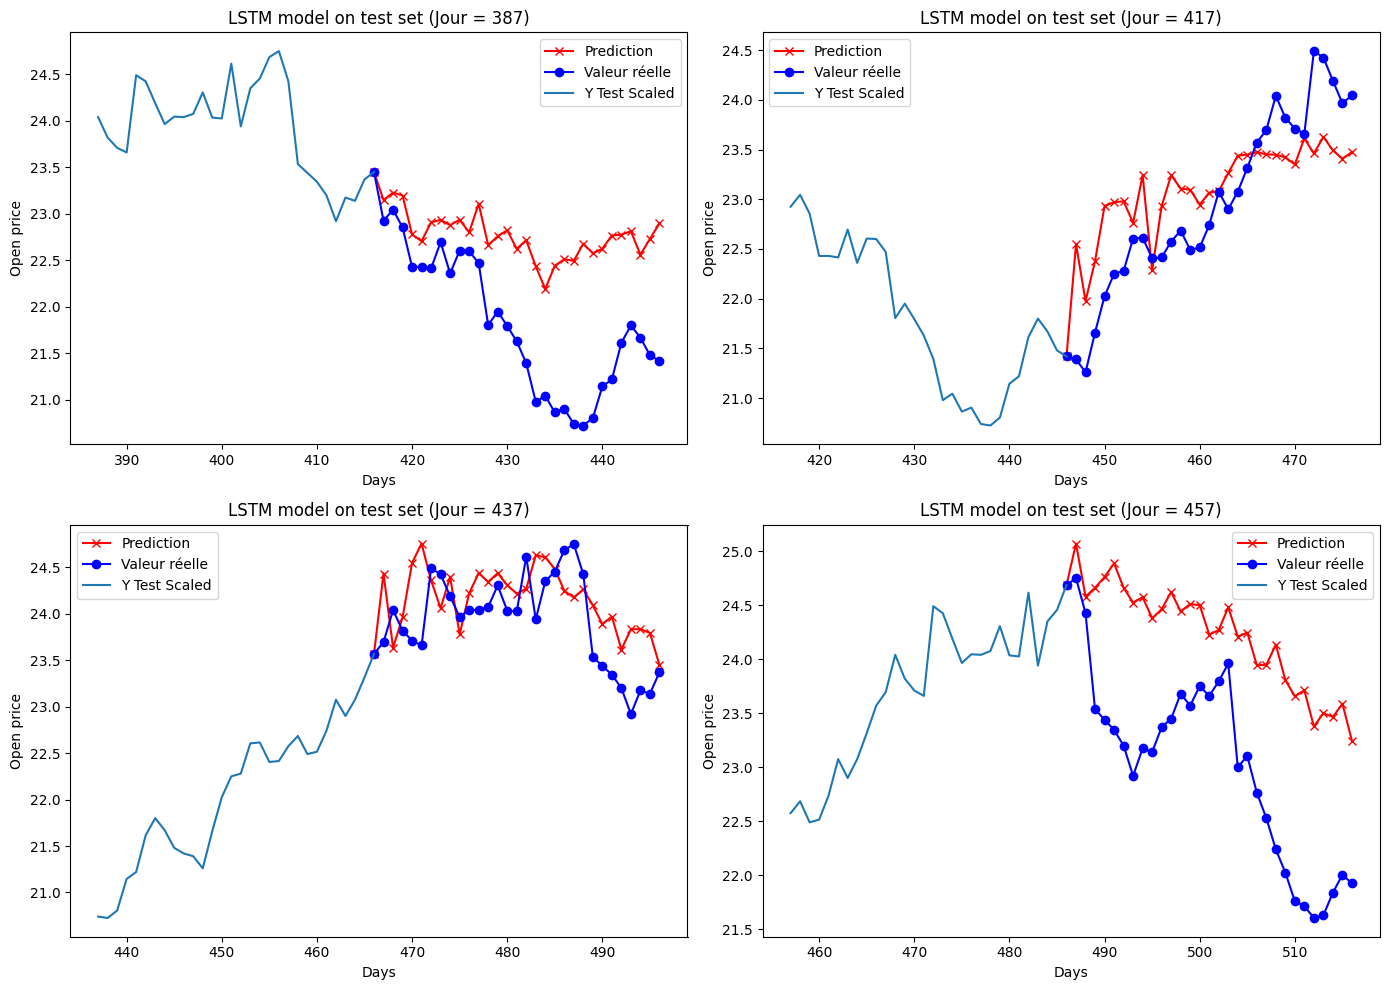

In [285]:
time_offsets = [0, 30, 50, 70]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for idx, offset in enumerate(time_offsets):
    time = fenetre + offset

    vecteur_predictions = np.insert(predictions_test[time], 0, y_test_scaled[time-futur_target][-1])
    vecteur_reel = np.insert(y_test_scaled[time], 0, y_test_scaled[time-futur_target][-1])

    i, j = divmod(idx, 2)

    axs[i, j].plot(range(fenetre + len(y_train) + time - 1, len(y_train) + fenetre + futur_target + time),
                   vecteur_predictions, "rx-", label="Prediction")
    axs[i, j].plot(range(fenetre + len(y_train) + time - 1, len(y_train) + fenetre + futur_target + time),
                   vecteur_reel, "bo-", label="Valeur réelle")
    axs[i, j].plot(range(fenetre + len(y_train) - futur_target + time, len(y_train) + fenetre + time),
                   y_test_scaled[time - futur_target], label="Y Test Scaled")

    axs[i, j].set_xlabel("Days")
    axs[i, j].set_ylabel("Open price")
    axs[i, j].set_title(f"LSTM model on test set (Jour = {fenetre + len(y_train) - futur_target + time})")
    axs[i, j].legend()

plt.tight_layout()
plt.show()